
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>
 
 
# Laboratorio: Análisis y Modelado de Series Temporales con SARIMAX

En este laboratorio, practicarás el análisis y modelado de series temporales utilizando el modelo SARIMAX. 
Objetivos del laboratorio

- Analizar series temporales:
	
    - Identificar tendencias, estacionalidad y posibles rupturas estructurales en los datos.
	
    - Verificar la estacionaridad de la serie mediante pruebas estadísticas y visuales.
	
    - Realizar análisis de autocorrelación (ACF) y autocorrelación parcial (PACF).

- Modelar la serie temporal:
	
    - Ajustar un modelo SARIMAX adecuado para los datos proporcionados.
	
    - Evaluar los resultados del modelo e interpretar los parámetros obtenidos.

- Interpretar gráficas y resultados:
	
    - Explicar de forma detallada el significado de las gráficas y resultados generados durante cada etapa del análisis.

# Instrucciones

- Parte 1: Carga y exploración inicial de los datos

    - Descarga el conjunto de datos proporcionado, que contiene una serie temporal de valores relacionados con ventas mensuales de una empresa ficticia durante los últimos 5 años.

    - Realiza una exploración inicial:

        - Gráfica la serie temporal completa para identificar posibles tendencias y estacionalidades.

        - Comenta tus observaciones iniciales sobre los patrones que encuentres.

- Parte 2: Estacionaridad


    - Evalúa si la serie es estacionaria:

    - Aplica el test de Dickey-Fuller aumentado (ADF).

    - Si es necesario, realiza transformaciones (diferenciación o logaritmos) para convertir la serie en estacionaria.

    - Genera una gráfica comparativa que muestre la serie original y la transformada, indicando las diferencias visuales.

    - Escribe una interpretación de los resultados del test ADF y de la gráfica.

- Parte 3: Análisis de autocorrelaciones


    - Genera los gráficos de ACF (Autocorrelation Function) y PACF (Partial Autocorrelation Function).

    - Identifica:

        - El orden de diferenciación necesario (si aún no lo has hecho).

        - Los posibles valores para los parámetros p y q del modelo SARIMAX.

    - Explica qué indican las autocorrelaciones encontradas y cómo las utilizarás para definir los parámetros del modelo.

- Parte 4: Ajuste del modelo SARIMAX


    - Ajusta un modelo SARIMAX utilizando los parámetros identificados.

    - Evalúa el ajuste:

        - Observa los residuos del modelo.

        - Verifica si cumplen las condiciones de ruido blanco mediante análisis visual y pruebas estadísticas.

    - Ajusta el modelo si es necesario, iterando sobre los parámetros.

- Parte 5: Interpretación y predicción


    - Interpreta los coeficientes estimados del modelo (incluyendo estacionalidad y efectos externos si aplican).

    - Genera una predicción para los próximos 12 meses.

    - Gráfica las predicciones junto con la serie temporal original.

    - Comenta sobre:

        - La calidad de las predicciones.

        - La utilidad del modelo para la toma de decisiones.



---

## Importar librerías

In [ ]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Importar las clases
# -----------------------------------------------------------------------
from src.soporte_series import TimeSeriesAnalysis, SARIMAModel

# Ignore warnings  
# -----------------------------------------------------------------------  
import warnings  
warnings.filterwarnings("ignore") 

# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Carga de datos

In [58]:
# Cargar el archivo CSV
df = pd.read_csv("data/Truck_sales.csv")

# Convertir la columna 'Month-Year' en un objeto datetime (opcional)
df['Month-Year'] = pd.to_datetime(df['Month-Year'], format='%y-%b')

# Mostrar el DataFrame
df.set_index('Month-Year', inplace=True)

# Cambiar el nombre al índice
df.index.name = "Date"

In [59]:
df.head()

,Number_Trucks_Sold
Date,
2003-01-01,155
2003-02-01,173
2003-03-01,204
2003-04-01,219
2003-05-01,223


Vamos a hacer una copia para crear nuevas columnas

In [60]:
df_copia = df.copy().reset_index()
df_copia['Month'] = df_copia['Date'].dt.month
df_copia['Year'] = df_copia['Date'].dt.year

df_copia.head()

,Date,Number_Trucks_Sold,Month,Year
0,2003-01-01,155,1,2003
1,2003-02-01,173,2,2003
2,2003-03-01,204,3,2003
3,2003-04-01,219,4,2003
4,2003-05-01,223,5,2003


### Exploración de los datos

In [61]:
# instanciamos la clase
analisis_st = TimeSeriesAnalysis(df_copia, temporal_column="Date", value_column="Number_Trucks_Sold")

analisis_st.exploracion_datos()

El número de filas es 144 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Number_Trucks_Sold,144,429,189,152,274,406,560,958
Month,144,6,3,1,4,6,9,12
Year,144,2008,3,2003,2006,2008,2011,2014


Vemos una distribución de ventas bastante dispersa, con meses en los que se han vendido apenas 152 unidades mientras que se ha llegado a alcanzar un máximo de más de 950. 

El promedio ronda los 429 camiones con una desviación típica de 189.

No tenemos valores nulos, lo cual es una condición necesaria para construir un modelo de predicción de serie temporales.


### Consistencia temporal

Tenemos que verificar que los datos se encuentran equiespaciados en el tiempo, sin que haya lagunas ni agujeros.

Creamos el rango de fechas completo para ver si nos falta alguna. Especificamos "MS" en `freq` para que rellene solo meses, que es el delta que tenemos en este caso.

In [ ]:
# Rango de fechas completas
fecha_completa = pd.date_range(start=df_copia['Date'].min(), end=df_copia['Date'].max(), freq="MS")
fecha_completa

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

Ahora veamos los datos que tenemos y comprobamos si hay diferencias con el rango completo

In [74]:
# Completos
mes_anio_completo = fecha_completa.to_period("M")
# Los nuestros
mes_anio_actual = df.index.to_period("M")

In [75]:
mes_anio_actual.difference(mes_anio_completo)

PeriodIndex([], dtype='period[M]')

In [77]:
all(mes_anio_actual == mes_anio_completo)

True

Vemos que todos coinciden y no hay diferencias por lo que no nos falta ninguna entrada.

---

## Tendencias y estacionalidad

In [64]:
# visualizamos a ver si tenemos tendencia en nuestros datos
analisis_st.graficar_serie()

In [65]:
# visualizamos la media movil
analisis_st.graficar_media_movil(window=12)

Vemos que claramente existe una tendencia al aumento de ventas con el paso de los años. 

Se aprecia claramente que la media móvil es una función monótona creciente con el tiempo.

Los valores también parecen presentar estacionalidad con picos en los meses de verano y valles en la temporada de invierno.

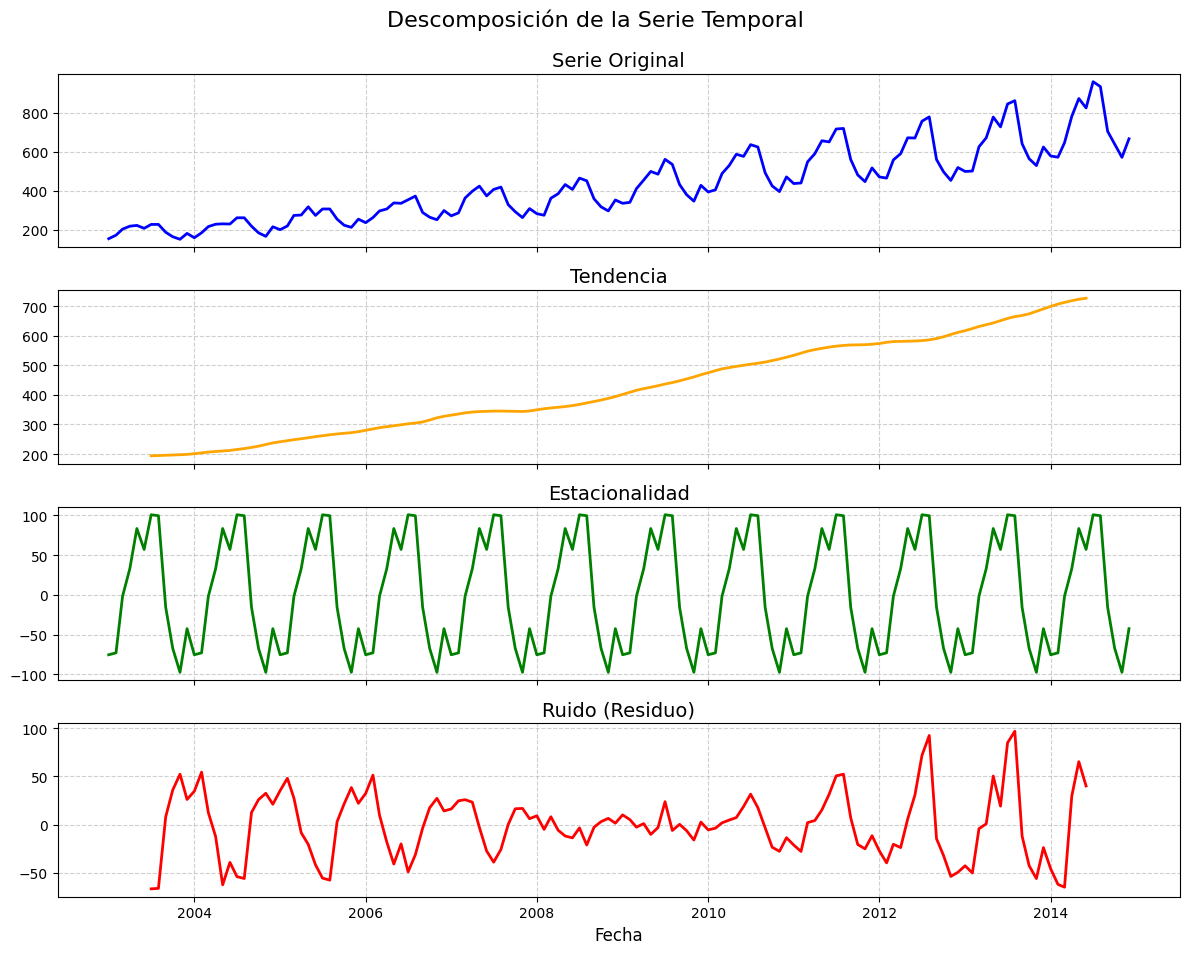

In [66]:
# vamos a ver si nuestros datos son estacionales
analisis_st.detectar_estacionalidad()

Aquí vemos claremente la tendencia creciente con los años y la regularidad del carácter estacional. 

También vemos que existe un ruido oscilante a lo largo de los años, con menor presencia entre 2008 y 2011

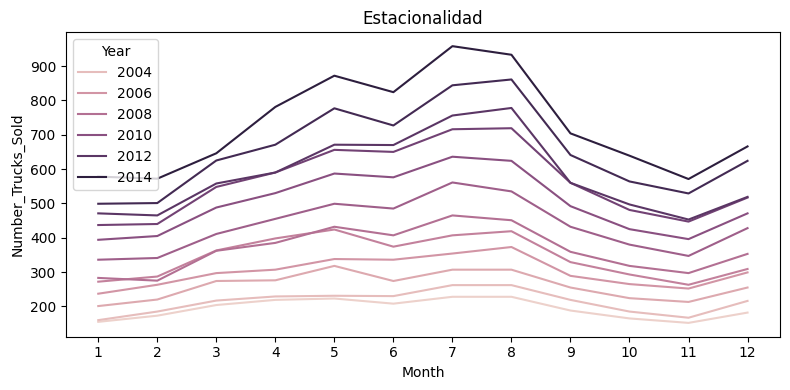

In [67]:
plt.figure(figsize=(8, 4))
sns.lineplot(x = "Month", 
             y = "Number_Trucks_Sold",
             hue='Year',
             data = df_copia)

plt.title("Estacionalidad")
plt.xticks(range(1,13))
plt.tight_layout()

En este gráfico se aprecia la estacionalidad, más acusada en los años más recientes. 

También podemos ver de nuevo el aumento general de las ventas con los años, que se evidencia en líneas sin apenas cruces entre sí.

Hagamos una prueba de estacionariedad mediante el test Dickey-Fuller

In [78]:
# Prueba de estacionariedad
analisis_st.prueba_estacionariedad()

ADF Statistic: 1.1158932574252716
p-value: 0.9953500083802602
Valores Críticos:
1%: -3.482087964046026
5%: -2.8842185101614626
10%: -2.578864381347275
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


---

## Análisis de autocorrelación

<Figure size 1200x1000 with 0 Axes>

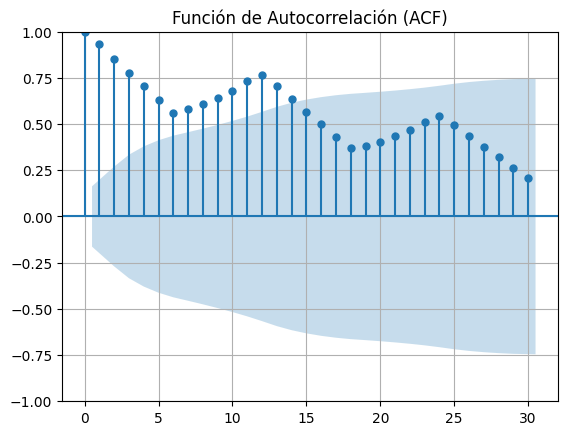

<Figure size 1200x1000 with 0 Axes>

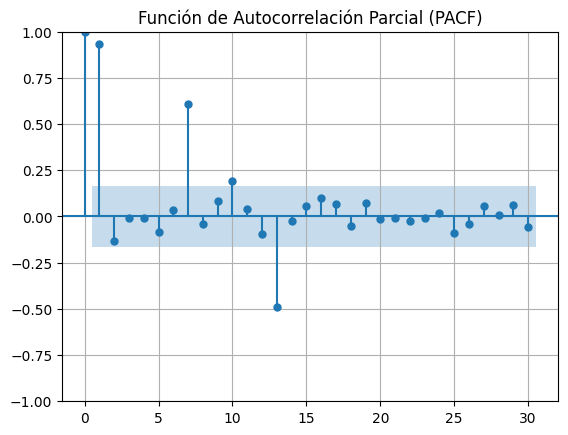

In [68]:
# Graficar ACF y PACF
analisis_st.graficar_acf_pacf(lags=30)

En la función de autocorrelación (ACF) podemos apreciar un patrón cíclico cada 12 lags, que se corresponde con el carácter estacional comentado anteriormente.

Tenemos un decaimiento general lento, que es una muestra más de la tendencia de los datos.

Hasta el lag 14 (bastantes) la autocorrelación está por encima del intervalo de confianza aceptable, esto sugiere nuevamente una tendencia a largo plazo.

En la función de autocorrelación parcial (PACF) vemos que solo son estadísticamente significativos los lags 0 y 1. Esto significa que los lags más allá de ellos tienen una influencia pequeña en los siguientes valores de la serie temporal

---

## Modelo Sarimax

Utilizaremos un modelo `Sarimax` ya que nuestros datos presentan estacionalidad.

Evaluaremos `q` hasta 11 (número de meses) y `p` hasta 3 (lag máximo en PACF).

### División del conjunto de datos

In [79]:
train_prop = 0.7

train_size = int(train_prop * len(df))
y_train, y_test = df[:train_size], df[train_size:]

In [82]:
sarima = SARIMAModel()

# Definir los rangos para los parámetros
p_range = range(1, 4) # De 1 a 3
q_range = range(1, 12) # De 1 a 11
seasonal_order_ranges = (
    range(2),  # P
    range(2),  # D
    range(2),  # Q
    [12]       # S, ciclos anuales
)

# Generar parámetros
parametros = sarima.generar_parametros(p_range, q_range, seasonal_order_ranges)
parametros[:5] # Ver algunas combinaciones

[(1, 1, (0, 0, 0, 12)),
 (1, 1, (0, 0, 1, 12)),
 (1, 1, (0, 1, 0, 12)),
 (1, 1, (0, 1, 1, 12)),
 (1, 1, (1, 0, 0, 12))]

100%|██████████| 264/264 [01:19<00:00,  3.34it/s]


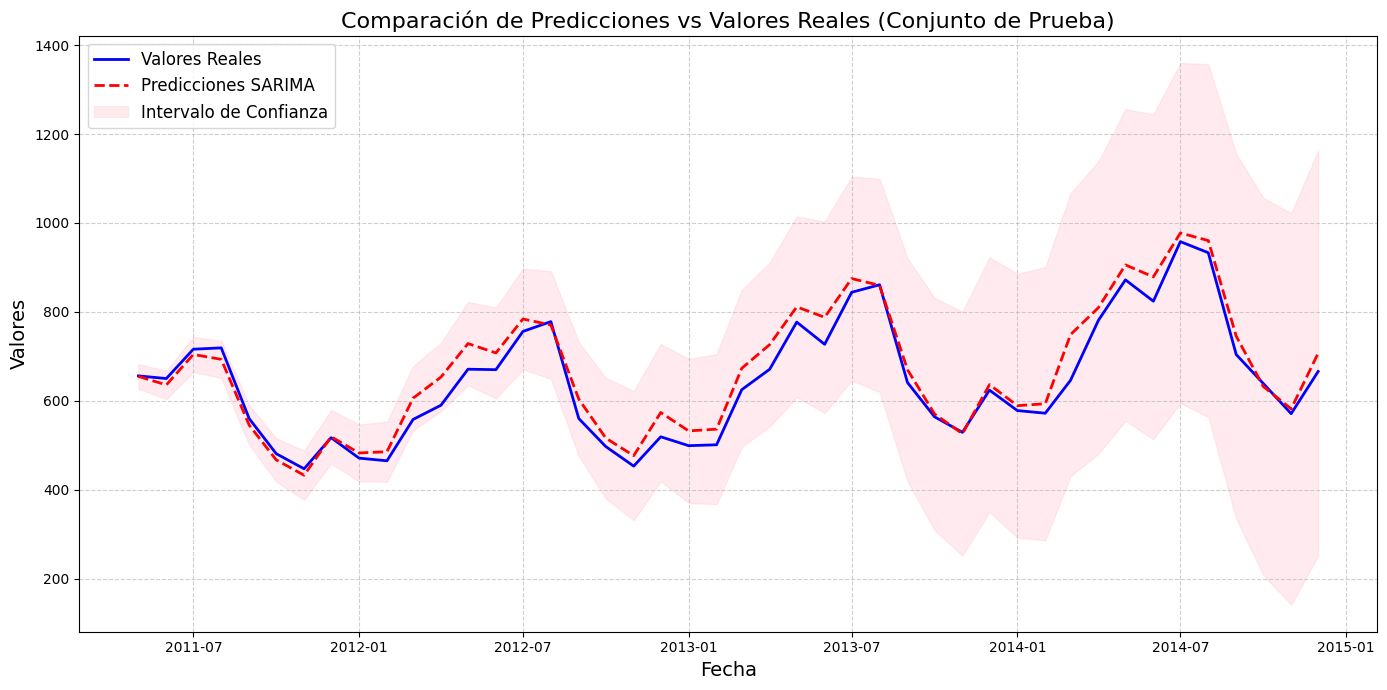

,p,q,seasonal_order,RMSE
244,3,9,"(1, 0, 0, 12)",35
124,2,5,"(1, 0, 0, 12)",36
159,2,9,"(1, 1, 1, 12)",36
63,1,8,"(1, 1, 1, 12)",36
79,1,10,"(1, 1, 1, 12)",37


In [86]:
# Evaluar modelos
results_df = sarima.evaluar_modelos(y_train, y_test, parametros, diferenciacion=1, df_length=len(df), variable="Number_Trucks_Sold")

# Ordenar resultados por RMSE
results_df = results_df.sort_values(by="RMSE", ascending=True)
results_df.head()

Vemos que el mejor modelo es capaz de predecir bastante bien las ventas de los camiones con un valor de RMSE de 35 respecto de un valores del orden de 700. Las mayores discrepancias se producen en las épocas de aumento de ventas, en las que la predicción es ligeramente optimista respecto de los valores reales.